# Direct imaging of exoplanets

Simple example of direct exoplanet imaging.


In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *
import pylops

import vip_hci as vip
from hciplot import plot_frames, plot_cubes

### Prepare data

The variable ``dataset`` contains a Betapic of size (612, 100, 100) where the first dimension is time and the other two are the spatial dimensions.  

We erase the star with the radius of 7 pixels around the center. The planet is located around $(61,61)$ pixel.

/home/vary/src/pynopt/data/sphere_k1_51eri_2016
Cube array shape: (256, 200, 200)
Angles array shape: (256,)
PSF array shape: (50, 50)
Normalized PSF array shape: (21, 21)
The attribute `psfn` contains the normalized PSF
`fwhm` attribute set to
4.863
New shape: (256, 100, 100)


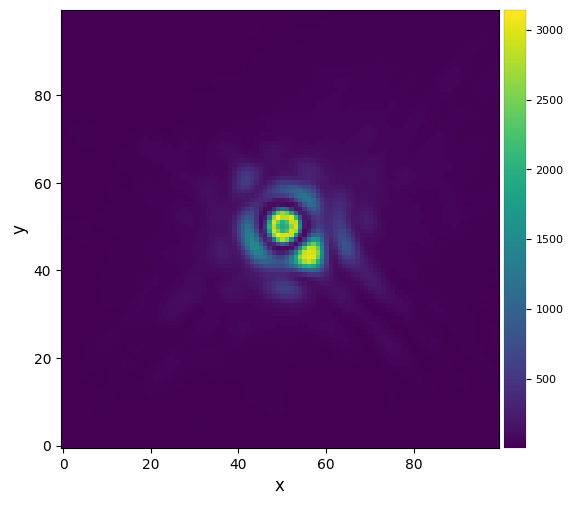

In [2]:
ROOT_PATH = '/home/vary/src/pynopt/'

def load_adi_dataset(adi_cube, psf, psf_size=None):
    adi_cube = os.path.join(ROOT_PATH, adi_cube)
    print(adi_cube)
    psf = os.path.join(ROOT_PATH, psf)
    dataset = vip.hci_dataset.Dataset(
        cube=vip.fits.open_fits(adi_cube,n=0, verbose=False),
        angles=vip.fits.open_fits(adi_cube,n=1, verbose=False),
        psf=vip.fits.open_fits(psf,verbose=False)
    )
    # Normalize PSF
    dataset.normalize_psf(verbose=False, size=psf_size)
    dataset.planets = []
    dataset.px_scale = 0.
    return dataset

def bpic_naco():
    dataset = load_adi_dataset(
        "data/bpic_naco",
        "data/naco_psf",
        psf_size=21
    )
    dataset.recenter(negative=True, plot=False, verbose=False)
    dataset.planets = [
        (16.26, 45.0)
    ]
    return dataset

def sphere_k1_51eri_2016():
    dataset = load_adi_dataset(
        "data/sphere_k1_51eri_2016",
        "data/sphere_k1_51eri_2016_psf",
        psf_size=21
    )
    dataset.planets = [
        (37.26, -101.6)
    ]
    return dataset

dataset = sphere_k1_51eri_2016()
dataset.crop_frames(100)

plot_frames(dataset.cube[40])

In [3]:
dataset.planets

[(37.26, -101.6)]

In [4]:
cube = dataset.cube
cy, cx = vip.var.frame_center(cube)
psf = dataset.psf
angles = dataset.angles
planets = dataset.planets

# Erase the star with the radius of 7 pixels around the center
r = 15
x = np.arange(0, cube.shape[2])
y = np.arange(0, cube.shape[1])
mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
mask = np.tile(mask,(cube.shape[0],1,1))
cube[mask] = 0


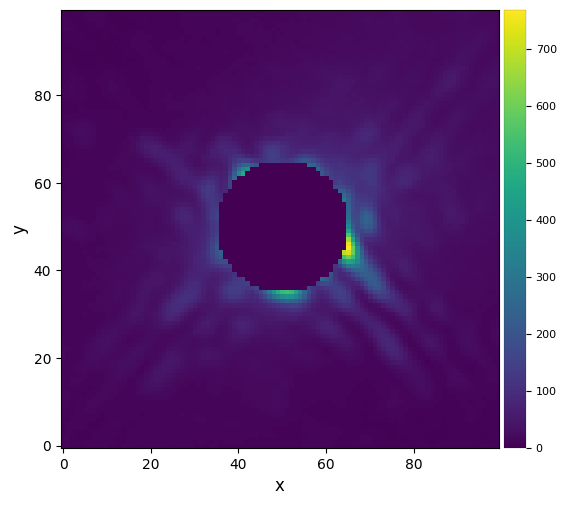

In [5]:
plot_frames(dataset.cube[40])

### PSF of the star / convolution kernel
Prepare kernel for detecting the star. We crop only the central part of the kernel to have a 9x9 filter that we will use for detection

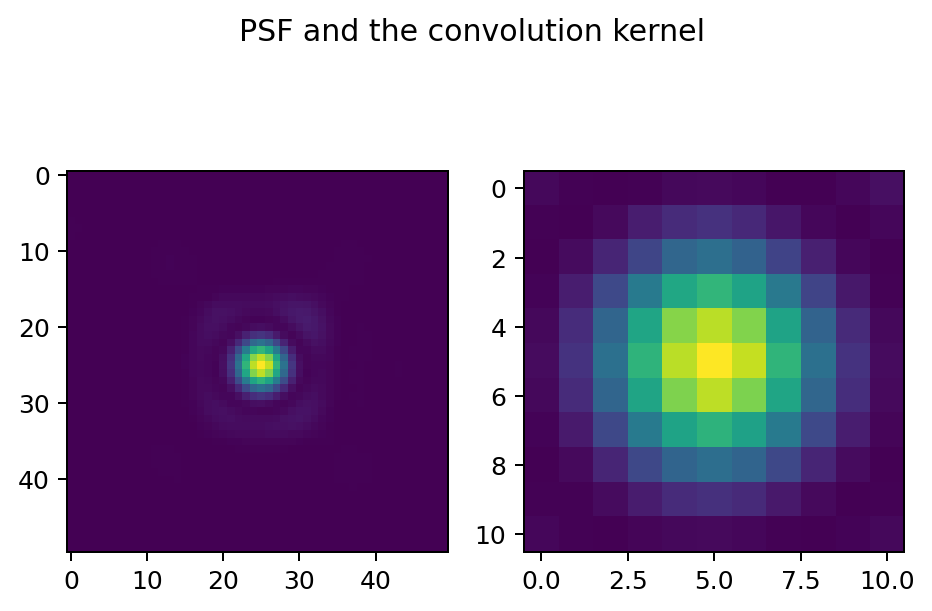

In [6]:
cx = psf.shape[0] // 2 + 1
cy = psf.shape[1] // 2 + 1
rx = 6
ry = 6
kernel = psf[cy-ry:cy+ry-1,cx-rx:cx+rx-1]
kernel = kernel / np.linalg.norm(kernel,ord = 'fro')

fig, axs = plt.subplots(1,2, dpi=180)
fig.suptitle('PSF and the convolution kernel')
plt1 = axs[0].imshow(psf)
plt2 = axs[1].imshow(kernel)
fig.show()

### Recovery model

We assume the following model:

$ X = L + \Psi(c)$

where $\mathrm{rank}(L)\leq r$, $\|c\|_0 \leq s$, and $\Psi: R^{N^2} :\rightarrow R^{T\times N^2}$ is a linear transform based on a 2D convolution I will refer to as __trajectorlet__. 

The adjoint transform of $\Psi^*(X)$ is performed to a matrix $(T, N^2)$ as follows:

1. First derotate the reshaped cube (T, N, N) based on the given angles
2. Then sum over the first dimension $T$ to get a matrix of $(N,N)$
3. Perform 2D convolution on the $(N,N)$ matrix using the PSF kernel and output a vectorized output with $N^2$ elements

The entries that have large coefficients denote which of the $N^2$ locations the planet trajectory likely starts at.

Similiarly, the forward operation is performed to a vector of size $N^2$ entries as follows:

1. First reshape the vector to an $(N,N)$ matrix and deconvolve using the same kernel resulting into an $(N, N)$ matrix
2. Reshape the matrix into an $N^2$ vector and copy it $T$ times to create a matrix of $(T, N^2)$
3. Perform derotation on the reshaped cube $(T, N, N)$ and return a matrix of size $(T, N^2)$

For a kernel (9, 9) whose Frobenius norm is equal to 1, this produces a tight frame operation.

In [7]:
class Trajectorlet(object):
    def __init__(self, shape, kernel, angles):
        '''
            Params:
                - shape (the dimensions of the data cube)
                - kernel (the psf kernel for convolution)
                - angles (list of rotated angles)
        '''
        self._kernel = kernel
        self._shape = shape
        self._angles = angles
        self._conv2d = pylops.signalprocessing.Convolve2D(
            N = np.prod(self._shape[-2:]),
            dims=self._shape[-2:],
            h=self._kernel,
            offset = (self._kernel.shape[0]//2+1, self._kernel.shape[1]//2+1)
        )

    def matvec(self, x): # Forward operation \Psi(c)
       y = self._conv2d.matvec(x)
       cube_out = np.tile(y, (self._shape[0], 1))
       cube_der = vip.preproc.cube_derotate(cube_out.reshape(self._shape), -self._angles, imlib='opencv')
       return cube_der.flatten() # reshape(self._shape[0],-1)

    def rmatvec(self, y): # Adjoint operation \Psi^T(y)
        der_cube = vip.preproc.cube_derotate(y.reshape(self._shape), self._angles, imlib='opencv')
        x = self._conv2d.rmatvec(der_cube.sum(axis=0).flatten())
        return x

### NAHT 

We solve the following minimization problem using NAHT algorithm (Algorithm 2 [arxiv](https://arxiv.org/pdf/2007.09457.pdf))

$$\min_{L\in \mathbb{R}^{m\times n},\,c\in\mathbb{R}^{n}} \| X - L - \Psi(c) \|_F^2, \qquad \mathrm{s.t.}\, \mathrm{rank}(L)\leq r,\quad \|c\|_0\leq s$$

where where $m = T$ and $n = N^2$ for a matrix format of the image sequence of $N\times N$ images in $T$ times. 

In [8]:
m = cube.shape[0]
n = np.prod(cube.shape[-2:])

r = 25
s = 10

HTr = FixedRank(r, (m,n))
HTs = PositiveSparsity(s)

# Prepare transform
trajectorlet = Trajectorlet(cube.shape, kernel, angles)
As = (None, trajectorlet)
b = cube.flatten()

In [9]:
problem = LinearProblemSum(As, b, (HTr, HTs))
solver = NAHT(logverbosity = 2, maxiter = 20, verbosity = 2, maxtime=60)

In [10]:
# This can take a while
x, opt_log = solver.solve(problem)

 iter		   obj. value	    grad. norm
    1	+1.4706792139469266e+07	3.08623853e+03
    2	+1.4706191013566971e+07	3.08580566e+03
    3	+1.4705587251899719e+07	3.08562549e+03
    4	+1.4704980854630589e+07	3.08523657e+03
    5	+1.4704369173982620e+07	3.08460010e+03
    6	+1.4703765449714661e+07	3.08423120e+03
    7	+1.4703159090008855e+07	3.08376123e+03
    8	+1.4702558038360596e+07	3.08343164e+03
    9	+1.4701959646721363e+07	3.08321558e+03
   10	+1.4701342733576894e+07	3.08267969e+03
   11	+1.4700741719055653e+07	3.08215503e+03
   12	+1.4700140716819882e+07	3.08178613e+03
   13	+1.4699539726869583e+07	3.08198706e+03
   14	+1.4698922864499211e+07	3.08088892e+03
   15	+1.4698316604652882e+07	3.08050854e+03
   16	+1.4697710357309461e+07	3.08026611e+03
   17	+1.4697106769755483e+07	3.07970264e+03
   18	+1.4696497900131345e+07	3.07935864e+03
   19	+1.4695889043119550e+07	3.07898242e+03
   20	+1.4695282845842361e+07	3.07847412e+03
Terminated - max iterations reached after 50.19 seconds.



The $\Psi(c)$ component reveals the planet, which is supposed to be located around $(61,61)$.

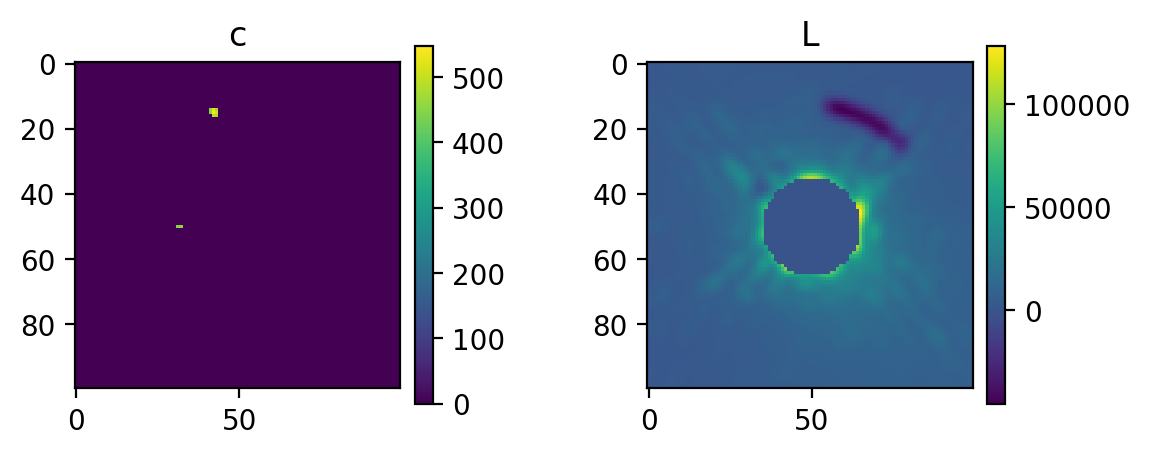

In [11]:
fig, axs = plt.subplots(1,2, dpi=200)
plt1 = axs[0].imshow(x[1].reshape(cube.shape[-2:]))
plt2 = axs[1].imshow(x[0].reshape(cube.shape).sum(axis=0))
plt.colorbar(plt1, ax=axs[0],fraction=0.05, pad=0.04)
plt.colorbar(plt2, ax=axs[1],fraction=0.05, pad=0.04)
axs[0].title.set_text('c')
axs[1].title.set_text('L')
fig.subplots_adjust(wspace=0.6)
fig.show()

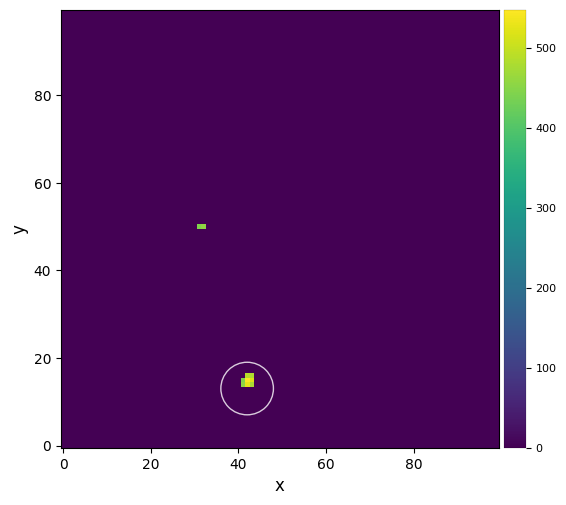

In [12]:
plot_frames(x[1].reshape(cube.shape[-2:]), circle=(-7.49+49.5, -36.49+49.5))

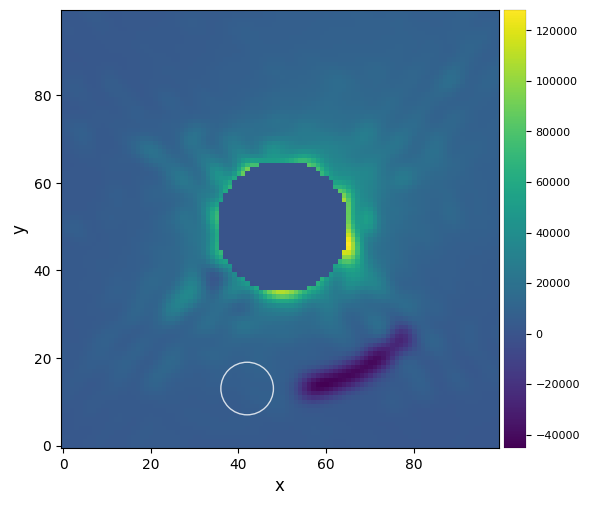

In [13]:
plot_frames(x[0].reshape(cube.shape).sum(axis=0), circle=(-7.49+49.5, -36.49+49.5))

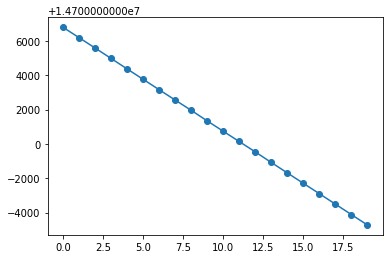

In [19]:
plt.plot(opt_log['iterations']['fx'], '-o')
plt.show()